# Generate the synthetic data from the Wong-Wang-Deco model

Approximate run duration: 5 mins

Generate the BOLD signal using the forward WWD model. 

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Work/Sciencing/Google_CoLab_projects/WWD_Model/WWD_pytorch/wwd-model-fitting/final/

/content/drive/MyDrive/Work/Sciencing/Google_CoLab_projects/WWD_Model/WWD_pytorch/wwd-model-fitting/final


In [3]:
import sys
sys.path.append('code/')

In [1]:

from rww_pytorch_model import RNNWWD, ParamsJR
from rww_pytorch_model import Model_fitting
import matplotlib.pyplot as plt # for plotting
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import seaborn as sns # for plotting 
import time # for timer
from scipy.io import loadmat # for reading in the .mat files

In [5]:
start_time = time.time()

# Define the WWD Model

For the synthetic BOLD signals, we can display the results of the forward model with the following global coupling strength parameters:
* `g` = 100
* `gEE` = 3.5
* `gIE` = 0.42
* `gEI` = 0.42

These are the model parameters that are known to fit based on the results of the Human Connectome Project (HCP) data. 

In [5]:
node_size = 66
output_size = 66
num_epoches = 100
batch_size = 20
step_size = .05
input_size = 2
tr = .75

G = 100
gEE = 3.5
gIE = 0.42
gEI = 0.42


sc_file = "../data/SC_Hagmann_CXIM.mat"
sc = loadmat(sc_file)['SC_66']
sc = sc -np.diag(np.diag(sc))
sc = 0.5*(sc.T+sc)
sc = np.log1p(sc)/np.linalg.norm(np.log1p(sc))

# make a fake ts
len_sim = 2400
ts = np.ones((len_sim, node_size))

# Initialise Model Parameters

init_params = ParamsJR("WWD", gEE = [3.5, 5], gIE = [0.42, 5], gEI = [0.42, 10], g_mean_ini = [100, 0], g_std_ini = [.1, 0], gEE_mean_ini = [2.5, 0], gEE_std_ini = [.1, 0])

dist = np.nan_to_num(1/sc)
dist[dist> 200] = 0

model = RNNWWD(input_size=input_size, node_size=node_size, batch_size=batch_size, step_size=step_size, tr=tr, sc=sc, dist=dist, fit_gains_flat=False, param=init_params)

      
# call model fit method
# F = Model_fitting(model, ts, num_epoches)
data_mean = [ts.T]*num_epoches
data_mean =np.array(data_mean)
F = Model_fitting(model, data_mean, num_epoches, 10, 0.0001)  # play around with the learning rate here


# output_test = F.test(240)
output_test = F.test(base_batch_num=240, x0=None, he0=None)

/var/folders/kc/0zmcgk1j313586f5z7yvtgjh0000gn/T/ipykernel_36209/2362008257.py:29: RuntimeWarning: divide by zero encountered in divide
  dist = np.nan_to_num(1/sc)


## Simulated functional connectivity analysis

In [6]:
# fc_sim = np.corrcoef(output_test['simBOLD'][:,2400:])
fc_sim = output_test

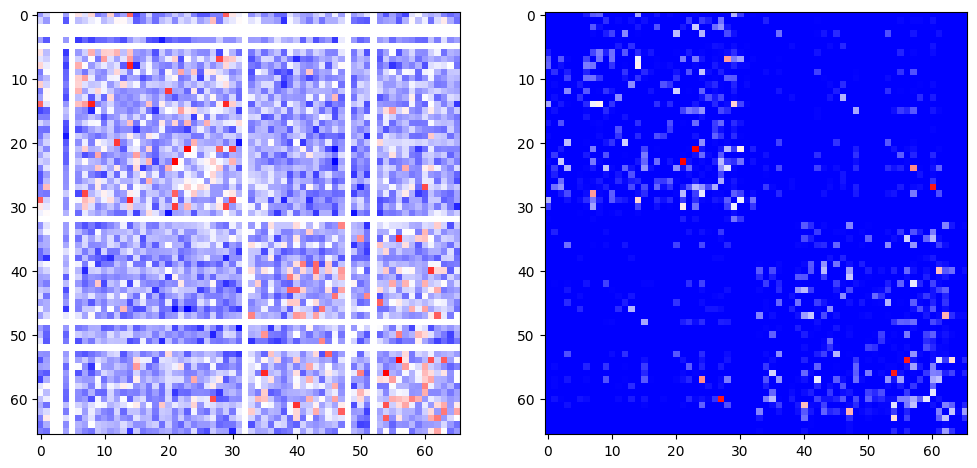

In [7]:
## connectivity 66
fig, ax=plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(fc_sim - np.diag(np.diag(fc_sim)), cmap='bwr')
ax[1].imshow(sc, cmap='bwr')
plt.show()

In [12]:
np.savetxt('../data/Hagmann/syn_ts.txt', output_test['simBOLD'].T)

In [13]:
end_time =  time.time()
print('running time is  {0} \'s'.format(end_time - start_time ))

running time is  193.50046467781067 's
